In [1]:
import os
import pandas as pd
import numpy as np
from stompy import utils
import six
import xarray as xr
import matplotlib.gridspec as gridspec
from stompy import filters
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils

%matplotlib notebook

In [2]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)
fig_dir="figs-20190419"
os.path.exists(fig_dir) or os.makedirs(fig_dir)

True

In [4]:
modelA=sun_driver.SuntansModel.load("/opt2/sfb_ocean/suntans/runs/merge_007-20170607/")
modelA.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [5]:
start=modelA.run_start
end  =modelA.run_stop

def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
pointreyes_wl=noaa_water_level(9415020,start,end,name="NOAA Point Reyes")
sanfran_wl=noaa_water_level(9414290,start,end,name="NOAA Fort Point")
coyote_wl=noaa_water_level(9414575,start,end,name="NOAA Coyote Creek")
richmond_wl=noaa_water_level(9414863,start,end,name="NOAA Richmond")
portchicago_wl=noaa_water_level(9415144,start,end,name="NOAA Port Chicago")


INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00
INFO:noaa_coops:Cached   2017-06-07 00:00:00 -- 2017-07-01 00:00:00


In [6]:

def combine_sources(all_sources,dt=np.timedelta64(900,'s')):
    # For many plots and metrics need a common timeline -- 
    # Get them on common time frames

    t_min=t_max=None
    for da in all_sources:
        if t_min is None or da.time[0]<t_min:
            t_min=da.time[0]
        if t_max is None or da.time[-1]>t_max:
            t_max=da.time[-1]
    dt=np.timedelta64(900,"s")  # compare at 15 minute intervals.
    resample_bins=np.arange(utils.floor_dt64(t_min,dt),
                            utils.ceil_dt64(t_max,dt)+dt,
                            dt)
    bin_labels=resample_bins[:-1]

    def resample(da):
        # groupby_bins allows for specifying the exact bins and labels,
        # simplifying concatenation below.
        da_r=(da.groupby_bins(da.time,resample_bins,labels=bin_labels)
              .mean()
              .rename(time_bins='time')
              .to_dataset())
        return da_r

    resampled=[resample(da) for da in all_sources]

    field_name=all_sources[0].name
    combined=xr_utils.concat_permissive(resampled,dim='source')[field_name]
    return combined


def assemble_comparison_data(models,observations,model_labels=None):
    # models: list of HydroModel instances
    # observations: list of DataArrays representing time series
    #   the first observation must have lon and lat fields
    #   defining where to extract data from in the model.
    # returns a list of dataarrays, and a combined dataset

    if model_labels is None:
        if len(models)==1:
            model_labels=["Model"]
        else:
            model_labels=["Model %d"%(i+1) for i,mod in enumerate(models)]

    # Extract relevant variable and location from model
    base_obs=observations[0] # defines the variable and location for extracting model data
    model_data=[] # a data array per model
    for model,label in zip(models,model_labels):
        ds=model.extract_station(ll=[base_obs.lon,base_obs.lat])
        if base_obs.name=='water_level':
            da=ds['eta']
            da.name='water_level' # having the same name helps later
        else:
            raise Exception("Not yet ready")
        da=da.assign_coords(label=label)
        model_data.append(da)
        
    # Annotate the sources with labels
    for i,da in enumerate(observations):
        if 'name' in da.attrs:
            label=da.attrs['name']
        else:
            label="Obs %d"%i
        da=da.assign_coords(label=label)
        observations[i]=da

    all_sources=model_data+observations
    combined=combine_sources(all_sources)
    return all_sources,combined


def calc_metrics(x,ref):
    """
    x, ref: DataArrays with common time dimension
    """
    metrics={}
    metrics['bias']=(x-ref).mean()
    valid=np.isfinite( (x+ref).values )
    metrics['r'] = np.corrcoef( x.values[valid],ref.values[valid])[0,1]
    metrics['lag']= utils.find_lag_xr(x,ref) 
    metrics['lag_s']=metrics['lag']/np.timedelta64(1,'s')
    metrics['amp']=np.std(x.values[valid]) / np.std(ref.values[valid])
    return metrics    
    

In [15]:

def fix_date_labels(ax):
    xfmt = dates.DateFormatter('%Y-%m-%d')
    xax=ax.xaxis
    xax.set_major_formatter(xfmt)
    xax.set_major_locator(dates.WeekdayLocator(byweekday=(1),
                          interval=1))
    
def calibration_figure_3panel(all_sources,combined,
                              metric_x=0,metric_ref=1,
                              offset_source=0,scatter_x_source=0,
                              styles=None):
    gs = gridspec.GridSpec(2, 3)
    fig=plt.figure(figsize=(9,7))
    ts_ax = fig.add_subplot(gs[0, :])
    lp_ax = fig.add_subplot(gs[1, :-1])
    scat_ax=fig.add_subplot(gs[1, -1])

    offsets=combined.mean(dim='time').values
    offsets-=offsets[offset_source]

    if styles is None:
        styles=[{}]*len(all_sources)

    if 1: # Tidal time scale plot:
        ax=ts_ax
        for src_i,src in enumerate(all_sources):
            ax.plot(src.time,src.values-offsets[src_i],
                    label=combined.label.isel(source=src_i).item(),
                    **styles[src_i])
        ax.legend(fontsize=8,loc='upper left')

    # Scatter:
    if 1:
        ax=scat_ax
        for i in range(len(combined.source)):
            if i==scatter_x_source: continue
            kw={}
            style=styles[i]
            for k in ['color','zorder']:
                if k in style:
                    kw[k]=style[k]
            ax.plot(combined.isel(source=scatter_x_source)-offsets[scatter_x_source],
                    combined.isel(source=i)-offsets[i],
                    '.',ms=1.5,**kw)
        ax.set_xlabel(combined.label.isel(source=scatter_x_source).item())
        
    # Metrics
    if metric_x is not None:
        ax=scat_ax # text on same plot as scatter
        metrics=calc_metrics(x=combined.isel(source=metric_x),
                             ref=combined.isel(source=metric_ref))
        lines=["Ampl: %.3f"%metrics['amp'],
               "Lag: %.1f min"%( metrics['lag_s']/60.),
               "Bias: %.2fm"%metrics['bias']]
        ax.text(0.05,0.95,"\n".join(lines),va='top',transform=ax.transAxes)

    # Lowpass:
    if 1:
        ax=lp_ax
        t=combined.time.values

        def lp(x): 
            x=utils.fill_invalid(x)
            dn=utils.to_dnum(t)
            cutoff=36/24.
            x_lp=filters.lowpass(x,dn,cutoff=cutoff)
            mask= (dn<dn[0]+2*cutoff) | (dn>dn[-1]-2*cutoff)
            x_lp[mask]=np.nan
            return x_lp
        for i in range(len(combined.source)):
            ax.plot(t,lp(combined.isel(source=i).values)-offsets[i],
                    label=combined.label.isel(source=i).item(),
                    **styles[i])
        #ax.legend(fontsize=8)

    #ts_ax.set_title(model.run_dir)
    fix_date_labels(ts_ax)
    fix_date_labels(lp_ax)
    return fig


In [16]:
bc_ref=modelA.extract_station(xy=[376354., 4235083.]).rename(eta='water_level')['water_level']
bc_ref.attrs['name']='B/C'

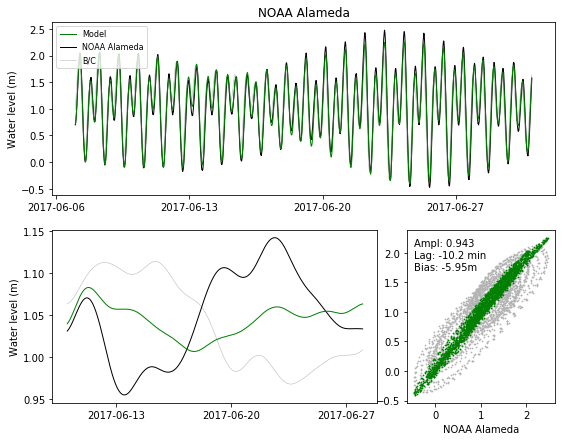

In [17]:
models=[modelA]
model_labels=[ os.path.basename(model.run_dir) for model in models]

for station in [alameda_wl,pointreyes_wl,sanfran_wl,coyote_wl,richmond_wl,
               portchicago_wl]:
    sources,combined=assemble_comparison_data(models,
                                              [station,bc_ref],
                                              model_labels=["Model"])
    fig=calibration_figure_3panel(sources,combined,scatter_x_source=1,offset_source=1,
                                  styles=[dict(color='g',lw=1.0,zorder=1),
                                          dict(color='k',lw=1.0,zorder=0),
                                          dict(color='0.7',zorder=-2,lw=0.5)])
    fig.axes[0].set_title(station.attrs['name'])
    for ax in fig.axes[:2]:
        ax.set_ylabel("Water level (m)")
    fig.savefig(os.path.join(fig_dir,"waterlevel-%s.png"%station.attrs['name'])) 
    break    


In [296]:
plt.close('all')